# Project: Advanced Lane Finding
---
### The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
---

## Import Packages

In [1]:
# importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
from time import sleep
%matplotlib inline

# global debug flags
DEBUG = True
DEBUG_2 = False

## Camera Calibration

No corners found in the following image: camera_cal\calibration1.jpg


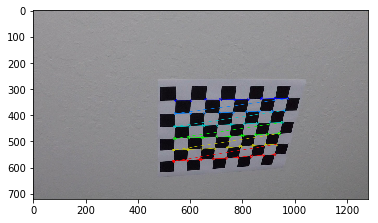

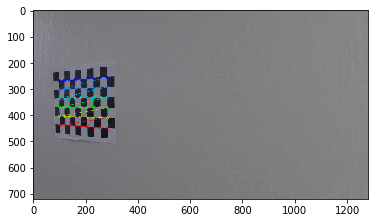

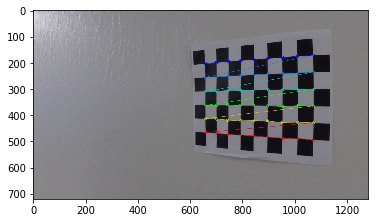

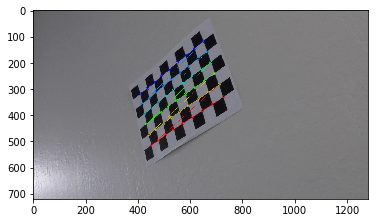

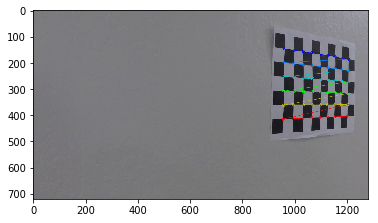

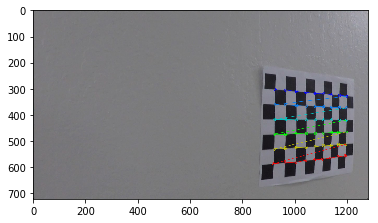

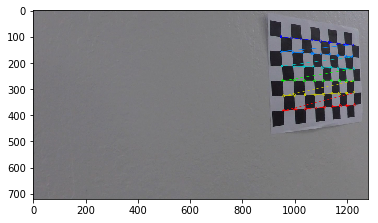

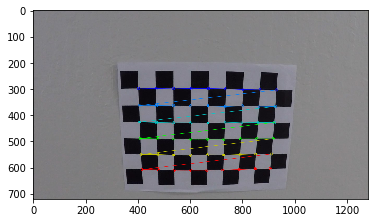

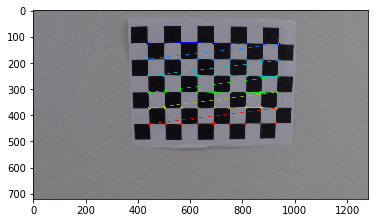

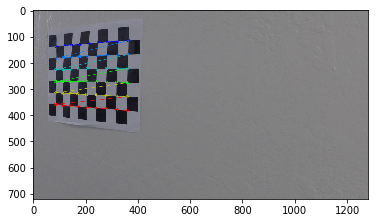

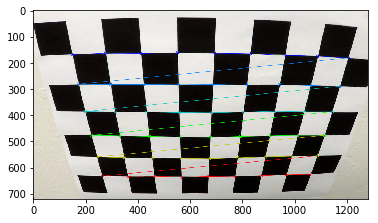

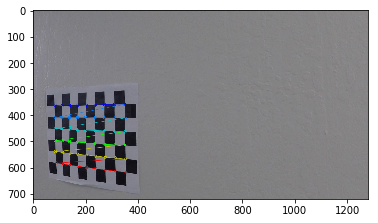

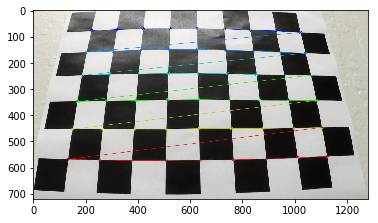

No corners found in the following image: camera_cal\calibration4.jpg
No corners found in the following image: camera_cal\calibration5.jpg


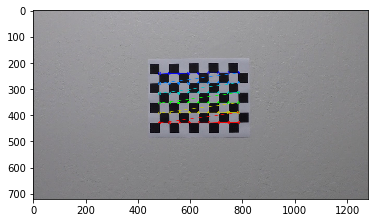

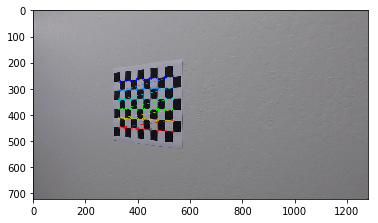

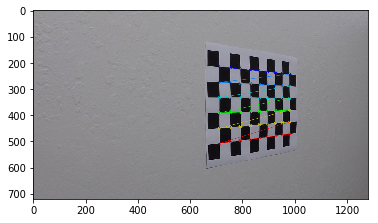

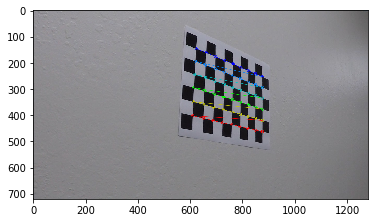

In [2]:
# prepare object points
nx = 9 # number of inside corners in x
ny = 6 # number of inside corners in y

objpoints = []
imgpoints = []

# Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ..., (nx-1,ny-1,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) # x, y coordinates

# Make a list of calibration images
fnames = glob.glob('camera_cal/calibration*.jpg')

# Iterate trough all calibration images
for fname in fnames:
    img = mpimg.imread(fname)
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, add object points and image points
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        if DEBUG:
            # Draw and display the corners
            cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
            plt.imshow(img)
            plt.show()
    else:
        if DEBUG: print("No corners found in the following image:", fname)


In [3]:
# Camera calibration
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[:2], None, None)

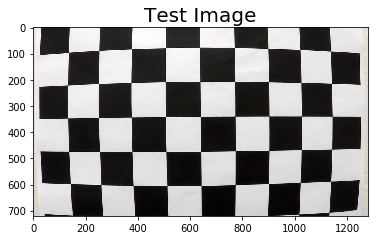

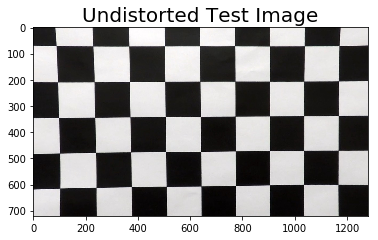

In [4]:
# Test camera calibration on one of the calibration images

img = mpimg.imread(fnames[0])
plt.title('Test Image', fontsize=20)
plt.imshow(img)
plt.show()

undist = cv2.undistort(img, mtx, dist, None, mtx)
plt.title('Undistorted Test Image', fontsize=20)
plt.imshow(undist)
plt.show()

## Helper Functions

In [5]:
# Definition of some helper functions and classes that will be used later

def undistort(img, mtx, dist):
    """
    This function receives a distorted image and returns it undistorted.
    Args:
        img: image to be undistorted
        mtx: camera matrix
        dist: distortion coefficients
    Returns:
        imgage: undistorted version of the input image
    """
    return cv2.undistort(img, mtx, dist, None, mtx)

def lane_filter(img, h_thresh=(15, 40), s_thresh=(175, 255), sx_thresh=(20, 100), white_thresh = 198):
    """
    This function receives a road image with lane lines and returns a binary image
    where the lane lines are marked with 1s and most of the rest is marked with 0s.
    
    Args:
        img (RGB-image): road image with lane lines
        h_thresh (int,int): min and max hue-value for HLS-image filter
        s_stesh (int,int): min and max saturation-value for HLS-image filter
        sx_thresh (int,int): min and max sobel-x-value
        white_thresh (int): min value for all RGB-color channels to find white pixels
    
    Returns:
        binary image: the lane lines are marked with 1s and most of the rest is marked with 0s
    """
    img = np.copy(img)
    
    r_channel = img[:,:,0]
    g_channel = img[:,:,1]
    b_channel = img[:,:,2]
    
    w_binary = np.zeros_like(r_channel)
    w_binary[(r_channel >= white_thresh) & (g_channel >= white_thresh) & (b_channel >= white_thresh)] = 1
    
    # Convert to HLS color space and separate the channels
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    #hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Threshold color channels
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    hs_binary = np.zeros_like(h_channel)
    hs_binary[(h_channel >= h_thresh[0]) & (h_channel <= h_thresh[1]) & (s_channel >= 90)] = 1
    
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize=3) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sx_binary = np.zeros_like(scaled_sobel)
    sx_binary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1]) & \
              (s_channel >= 12) & (l_channel >= 12)] = 1
    
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    #color_binary = np.dstack((hs_binary, s_binary, sxbinary))
    
    combined = np.zeros_like(s_binary)
    combined[(hs_binary == 1) | (s_binary == 1) | (w_binary == 1) | (sx_binary == 1)] = 1
    #combined[(sx_binary == 1)] = 1
    return combined

def fit_lines(binary_warped):
    """
    Fit two lane lines in a binary image using sliding window search.
    
    Args:
        binary_warped (binary image): warped binary image (bird's eye view),
            where ideally lane pixels are '1' and most other pixels are '0'
    Returns:
        left_fit, right_fit: second order polynomial coefficients that define the detected lane lines
    """
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # To be precise: the histogram is cut into seven parts
    # and we search only part 2 and 3 for the left starting point
    # and we search only part 5 and 6 for the right starting point:
    # 7 parts of the histogram:  |x|L|L|x|R|R|x|  (x: not searched, L/R: search for left/right starting point)
#     one7th = np.int(histogram.shape[0]/7.)
#     leftx_base = np.argmax(histogram[one7th : (3*one7th)]) + one7th
#     rightx_base = np.argmax(histogram[(4*one7th) : (6*one7th)]) + 4*one7th
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    if leftx.any():
        left_fit = np.polyfit(lefty, leftx, 2)
    else:
        left_fit = []
    if rightx.any():
        right_fit = np.polyfit(righty, rightx, 2)
    else:
        right_fit = [] 

    return left_fit, right_fit

def fit_lines_fast(binary_warped, left_fit, right_fit):
    """
    Fit two lane lines in a binary image based on previously detected lines.
    
    Args:
        binary_warped (binary image): warped binary image (bird's eye view),
            where ideally lane pixels are '1' and most other pixels are '0'
        left_fit (list): second order polynomial coefficients that define the last known left line
        right_fit (list): second order polynomial coefficients that define the last known right line
    Returns:
        left_fit, right_fit: second order polynomial coefficients that define the detected lane lines
    """
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit

def region_of_interest(img, vertices, inside=True):
    """
    Applies an image mask. For binary images only!
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black (for inside=True).
    Or vice versa if parameter "inside" is set to False.
    """
    # depending on the value of 'inside', define a all-zeros or all-ones mask to start with
    if inside:
        mask = np.zeros_like(img)
        mask_color = 1
    else:
        mask = np.ones_like(img)
        mask_color = 0
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)


## The Line and Lane classes

In [6]:
class Line():
    """
    A class to receive the characteristics of each line detection.
    This class also defines a couple of methods to handel this data.
    """
    def __init__(self, lane, position, hist_size=4, failed_max=5):
        # lane object which holds this line and the other line
        self.lane = lane
        # lane position, e.g. 'left' or 'right'
        self.position = position
        # number of recent fits that will be stored
        self.hist_size = hist_size
        # maximum number of failed detections in a row before the search history
        # will be deleted and the search will be started from scratch
        self.failed_max = failed_max
        
        # history of the last n fits...
        
        # was the line detected in the last iteration?
        self.detected = False
        # number of failed line detections in a row
        self.failed_count = 0
        # radius of curvature of the last n fits of the line in meters
        self.recent_radius = []
        # average radius of curvature of the last n fits of the line in meters
        self.best_radius = None
        # the mean x values of the last n fits of the line
        self.recent_x_mean = []
        # average mean x values of the fitted line over the last n iterations
        self.best_x_mean = None
        # polynomial coefficients of the last n fits of the line
        self.recent_fits = []
        # polynomial coefficients averaged over the last n iterations
        self.best_fit = None
        
        # values of current fit...
        
        # polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]
        # x values for detected line pixels
        self.allx = None
        # y values for detected line pixels
        self.ally = None
        # radius of curvature of the line in meters
        self.radius_of_curvature = None
        # distance in pixels of vehicle center from the line
        self.line_base_pos = None
    
    def calc_values_for_current_fit(self, current_fit):
        """
        Calculate all values for the current_fit, like x- and y-values for the lane line and its radius of curvature.
        
        Args:
            current_fit (list): polynomial coefficients for the most recent line fit
        Returns:
            None
        """
        self.current_fit = current_fit
        
        # Calculate the x and y values of the lane for the current fit
        self.ally = np.linspace(0, self.lane.img_size_y-1, self.lane.img_size_y)
        self.allx = current_fit[0]*self.ally**2 + current_fit[1]*self.ally + current_fit[2]
        
        # Calculate the radius of curvature in meters...
        
        # Define y-value where we want radius of curvature
        # I'll choose the maximum y-value, corresponding to the bottom of the image
        y_eval = int(np.max(self.ally))

        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension

        # Fit new polynomials to x,y in world space
        fit_cr = np.polyfit(self.ally*ym_per_pix, self.allx*xm_per_pix, 2)
        # Calculate the new radius of curvature
        self.radius_of_curvature = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
        
        # Calculate the distance in pixels of the vehicle center from the line
        # the center of the image in x direction is equivalent to the center of the vehicle
        self.line_base_pos = self.allx[y_eval] - (self.lane.img_size_x / 2.)
        
    def validate_current_fit(self):
        """
        Validate the current fit and if possible compare it to the history of detected lines.
        
        Args:
            -
        Returns:
            validation result (bool): True if the validation was successful, False if not.
        
        """
        if self.position == 'left':
            if self.line_base_pos > 0:
                if DEBUG: print('Bad line_base_pos for left line!')
                return False
        if self.position == 'right':
            if self.line_base_pos < 0:
                if DEBUG: print('Bad line_base_pos for right line!')
                return False
        
        if self.radius_of_curvature < 200.0:
            if DEBUG: print('Bad radius_of_curvature for {:} line!'.format(self.position))
            return False
        
        # Do history based checks, if we have a history with at least 2 entries
        if len(self.recent_fits) > 1:
            # We only check their ratio if both the current line and the best averaged line are not kind of straight
            kinda_straight_tresh = 2000.0
            if self.radius_of_curvature < kinda_straight_tresh and self.best_radius < kinda_straight_tresh:
                max_ratio = 5.
                min_ratio = 1./max_ratio
                if abs(self.radius_of_curvature / self.best_radius) < min_ratio:
                    if DEBUG: print('{:} radius_of_curvature is too small compared to average radius!'.format(self.position))
                    return False
                if abs(self.radius_of_curvature / self.best_radius) > max_ratio:
                    if DEBUG: print('{:} radius_of_curvature is too big compared to average radius!'.format(self.position))
                    return False
            # Check average x-value of this Line
            current_average_x = sum(self.allx)/len(self.allx)
            max_x_diff = 50
            if current_average_x > self.best_x_mean + max_x_diff:
                if DEBUG: print('{:} average x-value={:.2f} is too big compared to best_x_mean={:.2f}!' \
                                .format(self.position, current_average_x, self.best_x_mean))
                return False
            if current_average_x < self.best_x_mean - max_x_diff:
                if DEBUG: print('{:} average x-value={:.2f} is too small compared to best_x_mean={:.2f}!' \
                                .format(self.position, current_average_x, self.best_x_mean))
                return False
            
        return True
    
    def update_history(self, detected=False):
        """
        Updates the history of this Line object.
        When the line was detected (and validated) successfully (detected=True),
        the recent fit will be appended to the list of recent_fits and all kinds of average values will be calculated.
        If no line was detected or the detected line was not validated successfully (detected=False),
        the history attributes will not be changed, except for the 'failed_count' which will be incremented.
        
        Args:
            detected (bool): Should be True when the last line detection was successful, False otherwise.
        Returns:
            None
        """
        if DEBUG_2: print('Updating history for {:} line: detected={:}, self.failed_count={:}, self.failed_max={:}' \
                       .format(self.position, detected, self.failed_count, self.failed_max))
        
        if detected:
            self.detected = True
            self.failed_count = 0 # reset failed_count to 0
            
            # Remove oldest element(s), when list size is equal or bigger than hist_size
            if len(self.recent_radius) >= self.hist_size:
                self.recent_radius = self.recent_radius[-(self.hist_size-1):]
            # Append newest radius_of_curvature
            self.recent_radius.append(self.radius_of_curvature)
            # Calculate new mean
            self.best_radius = sum(self.recent_radius)/len(self.recent_radius)
            
            # Remove oldest element(s), when list size is equal or bigger than hist_size
            if len(self.recent_x_mean) >= self.hist_size:
                self.recent_x_mean = self.recent_x_mean[-(self.hist_size-1):]
            # Append newest x_mean-element (mean of self.allx)
            self.recent_x_mean.append(sum(self.allx)/len(self.allx))
            # Calculate new mean
            self.best_x_mean = sum(self.recent_x_mean)/len(self.recent_x_mean)
            
            # Remove oldest element(s), when list size is equal or bigger than hist_size
            if len(self.recent_fits) >= self.hist_size:
                self.recent_fits = self.recent_fits[-(self.hist_size-1):]
            # Append newest polynomial coefficients
            self.recent_fits.append(self.current_fit)
            # Calculate new mean for each of the polynomial coefficients
            self.best_fit = [sum(i)/len(self.recent_fits) for i in zip(*self.recent_fits)]
            
        else:
            self.detected = False
            self.failed_count += 1
            if self.failed_count > self.failed_max:
                #failed_count overflow --> reset history of this line object
                self.__init__(self.lane, self.position, hist_size=self.hist_size, failed_max=self.failed_max)
                if DEBUG: print('History of {:} line cleared. Because failed_max = {:} has been exceeded'.format(self.position, self.failed_max))
    
    def calculate_average_fit(self):
        """
        Calculate all values for the current fit like 'radius_of_curvature' using self.best_fit.
        When self.best_fit is None, do nothing and return None.
        
        Args:
            -
        Returns:
            best_fit (list): polynomial coefficients for the best averaged line fit
        """
        if self.best_fit is not None:
            self.calc_values_for_current_fit(self.best_fit)
        return self.best_fit

class Lane():
    """
    The Lane class holds two lane lines as objects of the class Line.
    """
    def __init__(self, img_size_x, img_size_y, lane_width=3.7, hist_size=3, failed_max=6):
        # x size of the lane image
        self.img_size_x = img_size_x
        # y size of the lane image
        self.img_size_y = img_size_y
        # Lane width in meters
        self.lane_width = lane_width
        
        # Create two Line objects
        self.left_line = Line(self, 'left', hist_size, failed_max)
        self.right_line = Line(self, 'right', hist_size, failed_max)
        
        # Vehicle position relative to the lane center in meters
        self.vehicle_position = None
    
    def calc_all_values_for_current_fit(self, left_fit, right_fit):
        """
        Calculates all values for the detected left and right lane line and also the current vehicle position.
        
        Args:
            left_fit (list): polynomial coefficients for the most recent left line fit
            right_fit (list): polynomial coefficients for the most recent right line fit
        Returns:
            None
        """
        self.left_line.calc_values_for_current_fit(left_fit)
        self.right_line.calc_values_for_current_fit(right_fit)
        self.calc_vehicle_position()
        
    def calc_vehicle_position(self):
        """
        Calculate vehicle position relative to middle the two lines
        
        Args: -
        Returns: None
        """
        # First calculate the distance of the two lane lines in pixels...
        line_dist_px = self.right_line.line_base_pos - self.left_line.line_base_pos
        # ...so we can calculate the 'pixels per meter' value
        px_per_meter = line_dist_px / self.lane_width
        
        mid_of_vehicle_px = img_size_x / 2.
        vehicle_pos_px = self.left_line.line_base_pos + (line_dist_px / 2.)
        self.vehicle_position = vehicle_pos_px / px_per_meter
        
        
    def validate_curvature_ratio(self, max_curvature_ratio=75.0):
        """
        Carry out a sanity check on the current rato of curvature of the two lines, if the lines are not quasi straight
        The line history will not be evaluated.
        
        Args:
            max_curvature_ratio (float): maximum ratio of curvature of the two lane lines
        Returns:
            check result (bool): True for success, False otherwise
        """
        
        # If both lines are kind of straight, we don't check the ratio
        kinda_straight_tresh = 1000.0
        if self.left_line.radius_of_curvature > kinda_straight_tresh and self.right_line.radius_of_curvature > kinda_straight_tresh:
            return True
        
        min_curvature_ratio = 1./max_curvature_ratio
        curvature_ratio = self.left_line.radius_of_curvature / self.right_line.radius_of_curvature
        if curvature_ratio <= max_curvature_ratio and curvature_ratio >= min_curvature_ratio:
            return True
        else:
            if DEBUG: print('curvature_ratio={:} is not between min={:} and max={:}'.format(curvature_ratio, min_curvature_ratio, max_curvature_ratio))
            return False

## Advanced Lane Detection Pipeline

In [16]:
def pipeline(image):
    """
    Advanced lane detection pipeline.
    
    Args:
        image (rgb-image): 
        left_line (Line): an object of the Line class which holds information about the recently detected left lane lines
        right_line (Line): same for the right lane line
    Returns:
        rgb-image: undistorted version of the original image including highlighting of the detected lane
    """
    # Make a copy of the input image, so we don't change the original
    img = image.copy()
    # Copy the Lane object which must have been defined outside of this function
    lane = my_lane
    # Make local copies of the image's x and y size
    img_size_x, img_size_y = lane.img_size_x, lane.img_size_y
    
    ### Apply a distortion correction to raw images. ################################################
    undist_img = undistort(img, mtx, dist)
    
    ### Use color transforms, gradients, etc., to create a thresholded binary image. ################
    #binary_img = lane_filter(img)
    filtered_img = lane_filter(undist_img)
    
    # Define a four sided polygon to mask the image
    imshape = filtered_img.shape
    poly_height = 0.40  # height of the polygon in proportion of the image height
    poly_bottom_width = 0.90  # in proportion of image width
    poly_top_width = 0.10  # in proportion of image width
    poly_x_offset = 0.02  # offset of the polygon in x direction in proportion of the image width
    vertices = np.array([[\
        (((1+poly_top_width)/2 + poly_x_offset) * imshape[1], (1-poly_height)*imshape[0]),\
        (((1-poly_top_width)/2 + poly_x_offset) * imshape[1], (1-poly_height)*imshape[0]),\
        (((1-poly_bottom_width)/2 + poly_x_offset) * imshape[1], imshape[0]),\
        (((1+poly_bottom_width)/2 + poly_x_offset) * imshape[1], imshape[0])]], dtype=np.int32)
    # The outside area of the polygon will be dismissed
    masked_filtered_img = region_of_interest(filtered_img, vertices)
    
    # Define a three sided polygon (triangle) to mask the image
    poly_height = 0.3
    poly_bottom_width = 0.45
    poly_x_offset = 0.02  # offset of the polygon in x direction in proportion of the image width
    vertices = np.array([[\
        ((0.5 + poly_x_offset) * img_size_x, (1-poly_height)*img_size_y),\
        (((1-poly_bottom_width)/2 + poly_x_offset) * img_size_x, img_size_y),\
        (((1+poly_bottom_width)/2 + poly_x_offset) * img_size_x, img_size_y)]], dtype=np.int32)
    # The outside area of the triangle will be left as it is, the inside will be dismissed
    masked_filtered_img = region_of_interest(masked_filtered_img, vertices, inside=False)
    
    line_image = np.copy(image)*0
    line_image[masked_filtered_img == 1] = [255,0,0]
    
    ### Apply a perspective transform to rectify binary image ("birds-eye view"). ###################
    dst_x_offset = 300
#     src = np.float32([[img_size_x/2 - 56, 456],[img_size_x/2 + 56, 456], \
#                      [img_size_x/2 + 420, 694],[img_size_x/2 - 420, 694]])
    src = np.float32([[img_size_x/2 - 56, 456],[img_size_x/2 + 56, 456], \
                     [img_size_x/2 + 447, 720],[img_size_x/2 - 447, 720]])
    # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
    dst = np.float32([[img_size_x/2 - dst_x_offset, 0],[img_size_x/2 + dst_x_offset, 0], \
                       [img_size_x/2 + dst_x_offset, 719],[img_size_x/2 - dst_x_offset, 719]])
    # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # e) use cv2.warpPerspective() to warp your image to a top-down view
    binary_warped = cv2.warpPerspective(masked_filtered_img, M, (img_size_x, img_size_y), flags=cv2.INTER_LINEAR)
    
    
    ### Detect lane pixels and fit to find the lane boundary. #######################################
    ### Determine the curvature of the lane and vehicle position with respect to center. ############
    
    if lane.left_line.detected and lane.right_line.detected:
        # If we have detected both lines last time, we run a quick search
        left_fit, right_fit = fit_lines_fast(binary_warped, lane.left_line.best_fit, lane.right_line.best_fit)
    else:
        # If we have not detected BOTH last time, we run a complete new serch (sliding window method)
        if DEBUG: print('Using fit_lines ("slow")')
        left_fit, right_fit = fit_lines(binary_warped)
    
    left_fit_status = 0
    right_fit_status = 0
    
    if left_fit == []: # we didn't find a left line
        if lane.left_line.recent_fits == []: # ...and we have no lines in the hisory?
            left_fit_status = 0 # we don't have any value for the left line
            if DEBUG: print("left_fit_status = 0")
        else:
            left_fit_status = 1 # we use an old average value for the left line
            if DEBUG: print("left_fit_status = 1")
            left_fit = lane.left_line.best_fit
    else:
        left_fit_status = 2 # all good
    
    if right_fit == []: # we didn't find a right line
        if lane.right_line.recent_fits == []: # ...and we have no lines in the hisory?
            right_fit_status = 0 # we don't have any value for the right line
            if DEBUG: print("right_fit_status = 0")
        else:
            right_fit_status = 1 # we use an old average value for the left line
            if DEBUG: print("right_fit_status = 1")
            right_fit = lane.right_line.best_fit
    else:
        right_fit_status = 2 # all good

    if left_fit_status and right_fit_status: # we have a fit for both lines
        # Calculate all required values for the current fit like lane pixels, curvature and vehicle position
        lane.calc_all_values_for_current_fit(left_fit, right_fit)
    elif left_fit_status: # we have a fit only for the left line
        lane.left_line.calc_values_for_current_fit(left_fit)
    elif right_fit_status: # we have a fit only for the right line
        lane.right_line.calc_values_for_current_fit(right_fit)
    
    
    # Do sanity checks...
    
    # Initialize check flags
    left_line_good, right_line_good, curvature_ratio_good = False, False, False
    
    # 1. Check individual lines
    # a) check left line if we have a left_fit
    if left_fit_status == 2: # we have a current left fit
        left_line_good = lane.left_line.validate_current_fit()
        if (not left_line_good) and (lane.left_line.recent_fits != []):
            # the current fit is bad but we can use the 'best fit' from the history
            left_fit = lane.left_line.best_fit
            lane.left_line.calc_values_for_current_fit(left_fit)
            left_line_good = True
            left_fit_status = 1 # we're using a value from history
            if right_fit_status:
                # we have updated our left_fit, so we need to recalculate the vehicle position if we also have a right fit
                lane.calc_vehicle_position()
    
    # b) check right line if we have a right_fit
    if right_fit_status == 2:  # we have a current right fit
        right_line_good = lane.right_line.validate_current_fit()
        if (not right_line_good) and (lane.right_line.recent_fits != []):
            # the current fit is bad but we can use the 'best fit' from the history
            right_fit = lane.right_line.best_fit
            lane.right_line.calc_values_for_current_fit(right_fit)
            right_line_good = True
            right_fit_status = 1 # we're using a value from history
            if left_fit_status:
                # we have updated our right_fit, so we need to recalculate the vehicle position if we also have a left fit
                lane.calc_vehicle_position()
    
    # 2. Check the curvature ratio if the individual lines are good
    if left_line_good and right_line_good:
        curvature_ratio_good = lane.validate_curvature_ratio()
    
    
    # Update history and calculate new best_fit
    if left_line_good and (left_fit_status == 2):
        lane.left_line.update_history(True)
    else:
        lane.left_line.update_history(False)
        
    if right_line_good and (right_fit_status == 2):
        lane.right_line.update_history(True)
    else:
        lane.right_line.update_history(False)
    
    # recalculate all necesary values with the new best fit (if we have one)
    left_fit = lane.left_line.calculate_average_fit()
    right_fit = lane.right_line.calculate_average_fit()
    if (left_fit is not None) and (right_fit is not None) and curvature_ratio_good:
        lane.calc_vehicle_position()
    else:
        # if one of the lines is missing, we just return the undistorted image
        if DEBUG: print('NO LANE OUTPUT!')
        return undist_img
    
    ploty = lane.left_line.ally
    left_fitx = lane.left_line.allx
    right_fitx = lane.right_line.allx
    
    # print the lane lines to an image...
#     lane_points = np.column_stack((ploty, left_fitx, right_fitx))
#     wraped_lane_img = np.copy(image)*0
#     wraped_lane_img[binary_warped == 1] = [255,255,255]
#     for lane_point in lane_points:
#         if lane_point[1] < img_size_x and lane_point[1] >= 0:
#             wraped_lane_img[int(lane_point[0]), int(lane_point[1])] = [255,0,0]
#         if lane_point[2] < img_size_x and lane_point[2] >= 0:
#             wraped_lane_img[int(lane_point[0]), int(lane_point[2])] = [255,255,0]
    
    
    ### Warp the detected lane boundaries back onto the original image and output the lanes. ########
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    #cv2.fillPoly(color_warp, np.array([[0,0],[200,0],[200,200],[0,200]], np.int32), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist_img, 1, newwarp, 0.3, 0)
    
    
    #### Output numerical estimation of lane curvature and vehicle position. ########################
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    # Output lane curvature radius
    text = 'Radius of cuvature: {:.0f} m'.format((lane.left_line.best_radius + lane.right_line.best_radius) / 2.)
    cv2.putText(result,text,(10,40), font, 1,(255,255,255),2,cv2.LINE_AA)
    if DEBUG:
        text = 'left_curverad: ' + str(lane.left_line.best_radius) + \
                'm, right_curverad: ' + str(lane.right_line.best_radius) + 'm'
        cv2.putText(result,text,(10,120), font, 1,(255,255,255),2,cv2.LINE_AA)
    
    # See if we are left or right of center
    if lane.vehicle_position > 0:
        left_right = 'left'
    else:
        left_right = 'right'
    
    # Output vehicle position
    text = "Vehicle is {:.2f} m {} of center.".format(abs(lane.vehicle_position), left_right)
    cv2.putText(result,text,(10,80), font, 1,(255,255,255),2,cv2.LINE_AA)
    
    return result

## Apply The Pipeline To Test Images

In [17]:
# Make a list of test images
fnames = glob.glob('test_images/*.jpg')

# Iterate trough all test images and apply the pipleline defined above

# for filename in fnames:
#     img = mpimg.imread(filename)
    
#     #Get image shape
#     img_size_y, img_size_x = img.shape[:2]
#     #Create a Lane object for that image shape
#     my_lane = Lane(img_size_x, img_size_y)
    
#     #Run the lane detection pipeline
#     result_img = pipeline(img)
    
#     # Plot the resulting image next to the original image
#     f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
#     f.tight_layout()
#     ax1.imshow(img)
#     ax1.set_title('Original Image', fontsize=30)
#     ax2.imshow(result_img)
#     ax2.set_title('Pipeline Result', fontsize=30)
#     plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#     plt.show()
    
#     # Save image
#     mpimg.imsave("output_images/" + filename.split('\\')[-1], result_img)
    
#     sleep(0.01)

## Apply The Pipeline To Videos

In [18]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

### project_video.mp4

In [19]:
output_file1 = 'output_videos/project_video_out.mp4'

clip1 = VideoFileClip("project_video.mp4").subclip(40,45.5) #use a subclip for debugging .subclip(start_second,end_second)
#clip1 = VideoFileClip("project_video.mp4")

#Get clip shape
img_size_x, img_size_y = clip1.size
#Create a Lane object for that image shape
my_lane = Lane(img_size_x, img_size_y)

clip1 = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time clip1.write_videofile(output_file1, audio=False)

Using fit_lines ("slow")
[MoviePy] >>>> Building video output_videos/project_video_out.mp4
[MoviePy] Writing video output_videos/project_video_out.mp4


 26%|█████████████████████▏                                                           | 36/138 [00:07<00:19,  5.13it/s]

Bad radius_of_curvature for right line!


 27%|█████████████████████▋                                                           | 37/138 [00:07<00:20,  5.01it/s]

Using fit_lines ("slow")
Bad radius_of_curvature for right line!


 28%|██████████████████████▎                                                          | 38/138 [00:07<00:21,  4.58it/s]

Using fit_lines ("slow")
Bad radius_of_curvature for right line!


 28%|██████████████████████▉                                                          | 39/138 [00:08<00:22,  4.36it/s]

Using fit_lines ("slow")
Bad radius_of_curvature for right line!


 29%|███████████████████████▍                                                         | 40/138 [00:08<00:23,  4.16it/s]

Using fit_lines ("slow")
Bad radius_of_curvature for right line!


 30%|████████████████████████                                                         | 41/138 [00:08<00:24,  4.01it/s]

Using fit_lines ("slow")


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [00:28<00:00,  5.07it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video_out.mp4 

Wall time: 29.3 s


In [20]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_file1))

### challenge_video.mp4

In [21]:
output_file2 = 'output_videos/challenge_video_out.mp4'

clip2 = VideoFileClip("challenge_video.mp4").subclip(0,5.5) #use a subclip for debugging .subclip(start_second,end_second)
#clip2 = VideoFileClip("challenge_video.mp4")

#Get clip shape
img_size_x, img_size_y = clip1.size
#Create a Lane object for that image shape
my_lane = Lane(img_size_x, img_size_y)

clip2 = clip2.fl_image(pipeline) #NOTE: this function expects color images!!
%time clip2.write_videofile(output_file2, audio=False)

Using fit_lines ("slow")
[MoviePy] >>>> Building video output_videos/challenge_video_out.mp4
[MoviePy] Writing video output_videos/challenge_video_out.mp4


  1%|▉                                                                                 | 2/165 [00:00<00:29,  5.58it/s]

right average x-value=871.83 is too small compared to best_x_mean=963.25!


  2%|█▍                                                                                | 3/165 [00:00<00:29,  5.44it/s]

Using fit_lines ("slow")


  3%|██▍                                                                               | 5/165 [00:00<00:30,  5.19it/s]

Bad radius_of_curvature for right line!


  4%|██▉                                                                               | 6/165 [00:01<00:30,  5.22it/s]

Using fit_lines ("slow")


  4%|███▍                                                                              | 7/165 [00:01<00:32,  4.80it/s]

Bad radius_of_curvature for right line!


  5%|███▉                                                                              | 8/165 [00:01<00:31,  4.96it/s]

Using fit_lines ("slow")
right average x-value=912.60 is too small compared to best_x_mean=967.72!


  5%|████▍                                                                             | 9/165 [00:01<00:32,  4.73it/s]

Using fit_lines ("slow")
Bad radius_of_curvature for right line!


  6%|████▉                                                                            | 10/165 [00:02<00:33,  4.58it/s]

Using fit_lines ("slow")


 13%|██████████▎                                                                      | 21/165 [00:04<00:27,  5.22it/s]

Bad radius_of_curvature for left line!


 13%|██████████▊                                                                      | 22/165 [00:04<00:27,  5.18it/s]

Using fit_lines ("slow")


 14%|███████████▎                                                                     | 23/165 [00:04<00:28,  5.05it/s]

Bad radius_of_curvature for left line!


 15%|███████████▊                                                                     | 24/165 [00:04<00:27,  5.20it/s]

Using fit_lines ("slow")
Bad radius_of_curvature for left line!


 15%|████████████▎                                                                    | 25/165 [00:05<00:27,  5.06it/s]

Using fit_lines ("slow")


 16%|████████████▊                                                                    | 26/165 [00:05<00:28,  4.93it/s]

Bad radius_of_curvature for left line!


 16%|█████████████▎                                                                   | 27/165 [00:05<00:29,  4.64it/s]

Using fit_lines ("slow")


 17%|█████████████▋                                                                   | 28/165 [00:05<00:30,  4.43it/s]

Bad radius_of_curvature for left line!


 18%|██████████████▏                                                                  | 29/165 [00:05<00:30,  4.52it/s]

Using fit_lines ("slow")
Bad radius_of_curvature for left line!


 18%|██████████████▋                                                                  | 30/165 [00:06<00:30,  4.43it/s]

Using fit_lines ("slow")


 19%|███████████████▏                                                                 | 31/165 [00:06<00:30,  4.37it/s]

Bad radius_of_curvature for left line!


 19%|███████████████▋                                                                 | 32/165 [00:06<00:29,  4.55it/s]

Using fit_lines ("slow")
Bad radius_of_curvature for left line!


 20%|████████████████▏                                                                | 33/165 [00:06<00:28,  4.58it/s]

Using fit_lines ("slow")
Bad radius_of_curvature for left line!


 21%|████████████████▋                                                                | 34/165 [00:07<00:28,  4.58it/s]

Using fit_lines ("slow")
Bad radius_of_curvature for left line!


 21%|█████████████████▏                                                               | 35/165 [00:07<00:28,  4.59it/s]

Using fit_lines ("slow")
Bad radius_of_curvature for left line!
Bad radius_of_curvature for right line!


 22%|█████████████████▋                                                               | 36/165 [00:07<00:28,  4.57it/s]

Using fit_lines ("slow")
Bad radius_of_curvature for left line!
Bad radius_of_curvature for right line!


 22%|██████████████████▏                                                              | 37/165 [00:07<00:27,  4.59it/s]

Using fit_lines ("slow")
Bad radius_of_curvature for left line!
History of left line cleared. Because failed_max = 6 has been exceeded
NO LANE OUTPUT!


 23%|██████████████████▋                                                              | 38/165 [00:07<00:27,  4.66it/s]

Using fit_lines ("slow")
Bad radius_of_curvature for left line!
Bad radius_of_curvature for right line!
NO LANE OUTPUT!


 24%|███████████████████▏                                                             | 39/165 [00:08<00:27,  4.63it/s]

Using fit_lines ("slow")
Bad radius_of_curvature for left line!
NO LANE OUTPUT!


 24%|███████████████████▋                                                             | 40/165 [00:08<00:27,  4.48it/s]

Using fit_lines ("slow")
Bad radius_of_curvature for left line!
Bad radius_of_curvature for right line!
NO LANE OUTPUT!


 25%|████████████████████▏                                                            | 41/165 [00:08<00:28,  4.34it/s]

Using fit_lines ("slow")
Bad radius_of_curvature for left line!
NO LANE OUTPUT!


 25%|████████████████████▌                                                            | 42/165 [00:08<00:27,  4.40it/s]

Using fit_lines ("slow")
Bad radius_of_curvature for left line!
right radius_of_curvature is too big compared to average radius!
NO LANE OUTPUT!


 26%|█████████████████████                                                            | 43/165 [00:09<00:28,  4.35it/s]

Using fit_lines ("slow")
Bad radius_of_curvature for left line!
NO LANE OUTPUT!


 27%|█████████████████████▌                                                           | 44/165 [00:09<00:29,  4.16it/s]

Using fit_lines ("slow")
Bad radius_of_curvature for left line!
History of left line cleared. Because failed_max = 6 has been exceeded
NO LANE OUTPUT!


 27%|██████████████████████                                                           | 45/165 [00:09<00:29,  4.14it/s]

Using fit_lines ("slow")
Bad radius_of_curvature for left line!
NO LANE OUTPUT!


 28%|██████████████████████▌                                                          | 46/165 [00:09<00:28,  4.18it/s]

Using fit_lines ("slow")
Bad radius_of_curvature for left line!
NO LANE OUTPUT!


 28%|███████████████████████                                                          | 47/165 [00:10<00:28,  4.19it/s]

Using fit_lines ("slow")
Bad radius_of_curvature for left line!
NO LANE OUTPUT!


 29%|███████████████████████▌                                                         | 48/165 [00:10<00:27,  4.18it/s]

Using fit_lines ("slow")
Bad radius_of_curvature for left line!
NO LANE OUTPUT!


 30%|████████████████████████                                                         | 49/165 [00:10<00:27,  4.27it/s]

Using fit_lines ("slow")
Bad radius_of_curvature for left line!
NO LANE OUTPUT!


 30%|████████████████████████▌                                                        | 50/165 [00:10<00:26,  4.33it/s]

Using fit_lines ("slow")
Bad radius_of_curvature for left line!
NO LANE OUTPUT!


 31%|█████████████████████████                                                        | 51/165 [00:10<00:26,  4.32it/s]

Using fit_lines ("slow")
Bad radius_of_curvature for left line!
History of left line cleared. Because failed_max = 6 has been exceeded
NO LANE OUTPUT!


 32%|█████████████████████████▌                                                       | 52/165 [00:11<00:26,  4.31it/s]

Using fit_lines ("slow")
Bad radius_of_curvature for left line!
NO LANE OUTPUT!


 32%|██████████████████████████                                                       | 53/165 [00:11<00:26,  4.30it/s]

Using fit_lines ("slow")
Bad radius_of_curvature for left line!
Bad radius_of_curvature for right line!
NO LANE OUTPUT!


 33%|██████████████████████████▌                                                      | 54/165 [00:11<00:25,  4.32it/s]

Using fit_lines ("slow")
Bad radius_of_curvature for left line!
Bad radius_of_curvature for right line!
NO LANE OUTPUT!


 33%|███████████████████████████                                                      | 55/165 [00:11<00:25,  4.34it/s]

Using fit_lines ("slow")
Bad radius_of_curvature for left line!
Bad radius_of_curvature for right line!
NO LANE OUTPUT!


 34%|███████████████████████████▍                                                     | 56/165 [00:12<00:25,  4.27it/s]

Using fit_lines ("slow")
Bad radius_of_curvature for left line!
right average x-value=959.44 is too big compared to best_x_mean=905.27!
NO LANE OUTPUT!


 35%|███████████████████████████▉                                                     | 57/165 [00:12<00:26,  4.12it/s]

Using fit_lines ("slow")
Bad radius_of_curvature for left line!
right average x-value=960.44 is too big compared to best_x_mean=905.27!
NO LANE OUTPUT!


 35%|████████████████████████████▍                                                    | 58/165 [00:12<00:27,  3.89it/s]

Using fit_lines ("slow")
Bad radius_of_curvature for left line!
History of left line cleared. Because failed_max = 6 has been exceeded
NO LANE OUTPUT!


 36%|████████████████████████████▉                                                    | 59/165 [00:13<00:29,  3.65it/s]

Using fit_lines ("slow")
Bad radius_of_curvature for left line!
NO LANE OUTPUT!


 36%|█████████████████████████████▍                                                   | 60/165 [00:13<00:28,  3.65it/s]

Using fit_lines ("slow")
Bad radius_of_curvature for left line!
Bad radius_of_curvature for right line!
NO LANE OUTPUT!


 37%|█████████████████████████████▉                                                   | 61/165 [00:13<00:27,  3.84it/s]

Using fit_lines ("slow")
Bad radius_of_curvature for left line!
Bad radius_of_curvature for right line!
NO LANE OUTPUT!


 38%|██████████████████████████████▍                                                  | 62/165 [00:13<00:26,  3.85it/s]

Using fit_lines ("slow")
Bad radius_of_curvature for left line!
Bad radius_of_curvature for right line!
NO LANE OUTPUT!


 38%|██████████████████████████████▉                                                  | 63/165 [00:14<00:26,  3.80it/s]

Using fit_lines ("slow")
Bad radius_of_curvature for left line!
Bad radius_of_curvature for right line!
NO LANE OUTPUT!


 39%|███████████████████████████████▍                                                 | 64/165 [00:14<00:25,  3.96it/s]

Using fit_lines ("slow")
Bad radius_of_curvature for left line!
Bad radius_of_curvature for right line!
NO LANE OUTPUT!


 39%|███████████████████████████████▉                                                 | 65/165 [00:14<00:24,  4.00it/s]

Using fit_lines ("slow")
Bad radius_of_curvature for left line!
Bad radius_of_curvature for right line!
History of left line cleared. Because failed_max = 6 has been exceeded
NO LANE OUTPUT!


 40%|████████████████████████████████▍                                                | 66/165 [00:14<00:25,  3.93it/s]

Using fit_lines ("slow")
Bad radius_of_curvature for left line!
NO LANE OUTPUT!


 41%|████████████████████████████████▉                                                | 67/165 [00:15<00:26,  3.76it/s]

Using fit_lines ("slow")
Bad radius_of_curvature for left line!
Bad radius_of_curvature for right line!
NO LANE OUTPUT!


 41%|█████████████████████████████████▍                                               | 68/165 [00:15<00:26,  3.65it/s]

Using fit_lines ("slow")
Bad radius_of_curvature for left line!
NO LANE OUTPUT!


 42%|█████████████████████████████████▊                                               | 69/165 [00:15<00:26,  3.69it/s]

Using fit_lines ("slow")
Bad radius_of_curvature for left line!
Bad radius_of_curvature for right line!
NO LANE OUTPUT!


 42%|██████████████████████████████████▎                                              | 70/165 [00:15<00:25,  3.79it/s]

Using fit_lines ("slow")
Bad radius_of_curvature for left line!
Bad radius_of_curvature for right line!
NO LANE OUTPUT!


 43%|██████████████████████████████████▊                                              | 71/165 [00:16<00:24,  3.86it/s]

Using fit_lines ("slow")
Bad radius_of_curvature for left line!
right average x-value=997.08 is too big compared to best_x_mean=943.16!
NO LANE OUTPUT!


 44%|███████████████████████████████████▎                                             | 72/165 [00:16<00:23,  3.89it/s]

Using fit_lines ("slow")
Bad radius_of_curvature for left line!
right average x-value=997.55 is too big compared to best_x_mean=943.16!
History of left line cleared. Because failed_max = 6 has been exceeded
NO LANE OUTPUT!


 44%|███████████████████████████████████▊                                             | 73/165 [00:16<00:25,  3.66it/s]

Using fit_lines ("slow")
Bad radius_of_curvature for left line!
right average x-value=1004.55 is too big compared to best_x_mean=943.16!
NO LANE OUTPUT!


 45%|████████████████████████████████████▎                                            | 74/165 [00:16<00:25,  3.62it/s]

Using fit_lines ("slow")
Bad radius_of_curvature for left line!
right average x-value=1006.98 is too big compared to best_x_mean=943.16!
NO LANE OUTPUT!


 45%|████████████████████████████████████▊                                            | 75/165 [00:17<00:24,  3.60it/s]

Using fit_lines ("slow")
Bad radius_of_curvature for left line!
right average x-value=1006.39 is too big compared to best_x_mean=943.16!
History of right line cleared. Because failed_max = 6 has been exceeded
NO LANE OUTPUT!


 46%|█████████████████████████████████████▎                                           | 76/165 [00:17<00:24,  3.68it/s]

Using fit_lines ("slow")
Bad radius_of_curvature for left line!
NO LANE OUTPUT!


 47%|█████████████████████████████████████▊                                           | 77/165 [00:17<00:25,  3.45it/s]

Using fit_lines ("slow")


 53%|██████████████████████████████████████████▋                                      | 87/165 [00:20<00:19,  4.08it/s]

Bad radius_of_curvature for left line!


 53%|███████████████████████████████████████████▏                                     | 88/165 [00:20<00:19,  3.87it/s]

Using fit_lines ("slow")


 54%|███████████████████████████████████████████▋                                     | 89/165 [00:20<00:19,  3.84it/s]

Bad radius_of_curvature for left line!


 55%|████████████████████████████████████████████▏                                    | 90/165 [00:21<00:18,  4.11it/s]

Using fit_lines ("slow")
Bad radius_of_curvature for left line!


 55%|████████████████████████████████████████████▋                                    | 91/165 [00:21<00:17,  4.19it/s]

Using fit_lines ("slow")


 56%|█████████████████████████████████████████████▏                                   | 92/165 [00:21<00:16,  4.32it/s]

Bad radius_of_curvature for left line!


 56%|█████████████████████████████████████████████▋                                   | 93/165 [00:21<00:15,  4.60it/s]

Using fit_lines ("slow")
Bad radius_of_curvature for left line!


 57%|██████████████████████████████████████████████▏                                  | 94/165 [00:22<00:15,  4.48it/s]

Using fit_lines ("slow")
Bad radius_of_curvature for left line!


 58%|██████████████████████████████████████████████▋                                  | 95/165 [00:22<00:17,  4.00it/s]

Using fit_lines ("slow")
Bad radius_of_curvature for left line!


 58%|███████████████████████████████████████████████▏                                 | 96/165 [00:22<00:16,  4.08it/s]

Using fit_lines ("slow")
Bad radius_of_curvature for left line!


 59%|███████████████████████████████████████████████▌                                 | 97/165 [00:22<00:16,  4.20it/s]

Using fit_lines ("slow")
Bad radius_of_curvature for left line!


 59%|████████████████████████████████████████████████                                 | 98/165 [00:23<00:16,  4.07it/s]

Using fit_lines ("slow")
Bad radius_of_curvature for left line!
History of left line cleared. Because failed_max = 6 has been exceeded
NO LANE OUTPUT!


 60%|████████████████████████████████████████████████▌                                | 99/165 [00:23<00:17,  3.76it/s]

Using fit_lines ("slow")
Bad radius_of_curvature for left line!
NO LANE OUTPUT!


 61%|████████████████████████████████████████████████▍                               | 100/165 [00:23<00:17,  3.67it/s]

Using fit_lines ("slow")
Bad radius_of_curvature for left line!
NO LANE OUTPUT!


 61%|████████████████████████████████████████████████▉                               | 101/165 [00:23<00:16,  3.95it/s]

Using fit_lines ("slow")
Bad radius_of_curvature for left line!
NO LANE OUTPUT!


 62%|█████████████████████████████████████████████████▍                              | 102/165 [00:24<00:17,  3.51it/s]

Using fit_lines ("slow")
Bad radius_of_curvature for left line!
NO LANE OUTPUT!


 62%|█████████████████████████████████████████████████▉                              | 103/165 [00:24<00:17,  3.51it/s]

Using fit_lines ("slow")
Bad radius_of_curvature for left line!
NO LANE OUTPUT!


 63%|██████████████████████████████████████████████████▍                             | 104/165 [00:24<00:16,  3.67it/s]

Using fit_lines ("slow")
Bad radius_of_curvature for left line!
NO LANE OUTPUT!


 64%|██████████████████████████████████████████████████▉                             | 105/165 [00:24<00:15,  3.81it/s]

Using fit_lines ("slow")
Bad radius_of_curvature for left line!
History of left line cleared. Because failed_max = 6 has been exceeded
NO LANE OUTPUT!


 64%|███████████████████████████████████████████████████▍                            | 106/165 [00:25<00:15,  3.88it/s]

Using fit_lines ("slow")
Bad radius_of_curvature for left line!
NO LANE OUTPUT!


 65%|███████████████████████████████████████████████████▉                            | 107/165 [00:25<00:14,  3.97it/s]

Using fit_lines ("slow")
Bad radius_of_curvature for left line!
NO LANE OUTPUT!


 65%|████████████████████████████████████████████████████▎                           | 108/165 [00:25<00:14,  4.04it/s]

Using fit_lines ("slow")
Bad radius_of_curvature for left line!
right average x-value=948.40 is too small compared to best_x_mean=999.66!
NO LANE OUTPUT!


 66%|████████████████████████████████████████████████████▊                           | 109/165 [00:25<00:13,  4.13it/s]

Using fit_lines ("slow")
Bad radius_of_curvature for left line!
right average x-value=942.67 is too small compared to best_x_mean=999.66!
NO LANE OUTPUT!


 67%|█████████████████████████████████████████████████████▎                          | 110/165 [00:26<00:13,  4.22it/s]

Using fit_lines ("slow")
Bad radius_of_curvature for left line!
right average x-value=936.62 is too small compared to best_x_mean=999.66!
NO LANE OUTPUT!


 67%|█████████████████████████████████████████████████████▊                          | 111/165 [00:26<00:12,  4.23it/s]

Using fit_lines ("slow")
Bad radius_of_curvature for left line!
right average x-value=936.37 is too small compared to best_x_mean=999.66!
NO LANE OUTPUT!


 68%|██████████████████████████████████████████████████████▎                         | 112/165 [00:26<00:12,  4.11it/s]

Using fit_lines ("slow")
Bad radius_of_curvature for left line!
right average x-value=926.84 is too small compared to best_x_mean=999.66!
History of left line cleared. Because failed_max = 6 has been exceeded
NO LANE OUTPUT!


 68%|██████████████████████████████████████████████████████▊                         | 113/165 [00:26<00:13,  3.84it/s]

Using fit_lines ("slow")
Bad radius_of_curvature for left line!
right average x-value=932.95 is too small compared to best_x_mean=999.66!
NO LANE OUTPUT!


 69%|███████████████████████████████████████████████████████▎                        | 114/165 [00:27<00:14,  3.53it/s]

Using fit_lines ("slow")
Bad radius_of_curvature for left line!
right average x-value=928.91 is too small compared to best_x_mean=999.66!
History of right line cleared. Because failed_max = 6 has been exceeded
NO LANE OUTPUT!


 70%|███████████████████████████████████████████████████████▊                        | 115/165 [00:27<00:13,  3.76it/s]

Using fit_lines ("slow")
Bad radius_of_curvature for left line!
NO LANE OUTPUT!


 70%|████████████████████████████████████████████████████████▏                       | 116/165 [00:27<00:12,  4.03it/s]

Using fit_lines ("slow")
Bad radius_of_curvature for left line!
NO LANE OUTPUT!


 71%|████████████████████████████████████████████████████████▋                       | 117/165 [00:27<00:11,  4.18it/s]

Using fit_lines ("slow")
Bad radius_of_curvature for left line!
NO LANE OUTPUT!


 72%|█████████████████████████████████████████████████████████▏                      | 118/165 [00:28<00:11,  4.17it/s]

Using fit_lines ("slow")
Bad radius_of_curvature for left line!
NO LANE OUTPUT!


 72%|█████████████████████████████████████████████████████████▋                      | 119/165 [00:28<00:10,  4.19it/s]

Using fit_lines ("slow")


100%|████████████████████████████████████████████████████████████████████████████████| 165/165 [00:38<00:00,  3.98it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/challenge_video_out.mp4 

Wall time: 40.8 s


In [22]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_file2))

### harder_challenge_video.mp4

In [14]:
# output_file3 = 'output_videos/harder_challenge_video_out.mp4'

# clip3 = VideoFileClip("harder_challenge_video.mp4").subclip(0,5) #use a subclip for debugging .subclip(start_second,end_second)
# #clip3 = VideoFileClip("harder_challenge_video.mp4")

# #Get clip shape
# img_size_x, img_size_y = clip1.size
# #Create a Lane object for that image shape
# my_lane = Lane(img_size_x, img_size_y)

# clip3 = clip3.fl_image(pipeline) #NOTE: this function expects color images!!
# %time clip3.write_videofile(output_file3, audio=False)

In [15]:
# HTML("""
# <video width="960" height="540" controls>
#   <source src="{0}">
# </video>
# """.format(output_file3))